In [206]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline
import os
import sys
import random
import mrcfile
import pandas
from io import StringIO
from PIL import Image as pil_image
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from scipy.fftpack import dct
import analysis_helper

In [2]:
import psutil
print(psutil.virtual_memory())
print(psutil.cpu_percent())

svmem(total=16759578624, available=14622511104, percent=12.8, used=1794691072, free=14539157504, active=1515610112, inactive=259190784, buffers=32321536, cached=393408512, shared=54321152, slab=144392192)
0.0


In [3]:
def plot_data_cm(data, ax, cmap="viridis"):
    im = ax.imshow(data, cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis('off')

def plot_data(mean_data, ax):
    im = ax.imshow(mean_data, cmap="gray")
    ax.axis('off')
    
def remove_background(image, sigma=40):
    mean = gaussian_filter(image, sigma)
    image = image - mean
    return image

def get_entropy(frame):
    (h, coords) = np.histogram(frame[frame!=0].ravel(), bins=50, density=True)
    h[h==0] = 1
    return -np.sum(h*np.log(h))
    

In [4]:
data_dir = '../cryoem_data/'
cryoem_files = [f for f in sorted(os.listdir(data_dir)) if f[-3:] == 'mrc' ]
star_files = [f for f in sorted(os.listdir(data_dir)) if f[-4:] == 'star' ]
data_file = data_dir+cryoem_files[0]
print('Found {} *.map files and {} *.star files'.format(len(cryoem_files), len(star_files)))

Found 93 *.map files and 93 *.star files


In [ ]:
mrc_data = []
for data_file in cryoem_files:
    mrc = mrcfile.open(data_dir + data_file, mode='r', permissive=True)
    mrc_data.append(np.copy(mrc.data))
    
mrc_data = np.stack(mrc_data)

In [ ]:
particle_coords = []
for i, star_file in enumerate(star_files):
    coords = []
    for l in open(data_dir+star_file, 'r'):
        l = l.strip().split()
        if len(l) < 5:
            continue
        coords.append([float(l[0]), float(l[1])])
        
    particle_coords.append(np.array(coords))

In [ ]:
i = np.random.randint(mrc_data.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8,8))

plot_data(mrc_data[i], ax)
ax.set_title(cryoem_files[i])

patches_list = []
for idx in particle_coords[i]:
    c = Circle((float(idx[0]), float(idx[1])), 100)
    patches_list.append(c)
    
p = PatchCollection(patches_list, edgecolor='b', linewidths=1, facecolor='none')
ax.add_collection(p)

In [ ]:
def extract_particles(image, particle_coords, box_size=100):
    particle_list = []
    for x,y in particle_coords:
        startx, endx = int(x - box_size//2), int(x + box_size//2)
        starty, endy = int(y - box_size//2), int(y + box_size//2)

        particle_list.append(image[starty:endy, startx:endx])
    
    return np.stack(particle_list)


particles = []
for i, image in enumerate(mrc_data):
    print('\r{}/{} {}%'.format(i+1, len(mrc_data), int(100.0*(i+1)/mrc_data.shape[0])), end='')
    image -= np.mean(image)

    # Remove bg takes a lot of time
#     image = remove_background(image)

    particles.append(extract_particles(image, particle_coords[i]))
    
particles = np.vstack(particles)

In [ ]:
np.save(data_dir+'particles_100', particles)

In [5]:
particles = np.load(data_dir+'particles_100.npy')

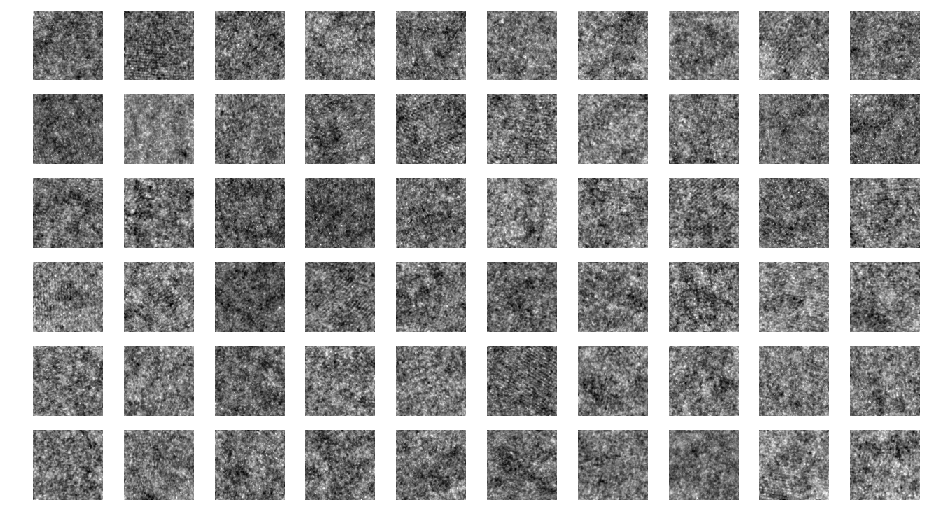

In [6]:
fig, ax = plt.subplots(6, 10, figsize=(16,9))
for i, ax in enumerate(ax.flatten()):
    plot_data(particles[i],ax)

In [7]:
def compute_fvs(particles, fv_len=50):
    N, nx, ny = particles.shape
    xi, yi, nr, nt = analysis_helper.getXiYiForPolarCoords(particles.shape[-2:], rmax=min(nx//2, ny//2))
    
    fvs = []
    for p in particles:
        p -= np.amin(p) # Make data > 0
        polar_p = analysis_helper.reprojectImageByCoords(p, xi, yi, nr, nt)
        ccf2d = analysis_helper.correlate_by_angle(polar_p)
        ccf_a = analysis_helper.combine_ccf_for_angles(ccf2d)
        fv = dct(ccf_a, norm='ortho')[:fv_len] # Ortho don't affect quality
        fv[0] = 0
        fvs.append(fv)
    
    return np.stack(fvs)

fvs = compute_fvs(particles)

In [ ]:
np.save(data_dir+'feature_vectors', fvs)

In [ ]:
fvs = np.load(data_dir+'feature_vectors.npy')

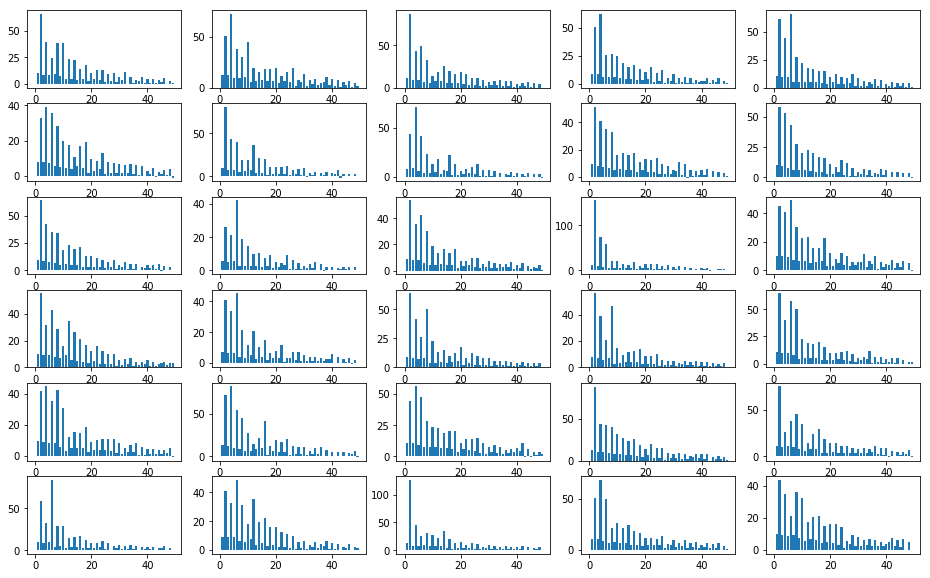

In [8]:
fig, ax = plt.subplots(6, 5, figsize=(16,10))
for i, ax in enumerate(ax.flatten()):
    ax.bar(range(fvs.shape[1]),fvs[i])

In [9]:
def compute_pca(input_data):
    """Compute Principle Component Analysis (PCA) transformation of input data

    Args:
        input_data: input data to be transformed
    Return:
        PCA transformation of input data in new basis
    """
    input_data = input_data - input_data.mean(axis=0)
    _, _, v = np.linalg.svd(input_data, full_matrices=False)
    return np.dot(input_data, v.T)

pca_result = compute_pca(fvs)

In [10]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, Birch, DBSCAN
from sklearn.cluster import FeatureAgglomeration, MiniBatchKMeans, MeanShift, SpectralClustering

/home/serge/anaconda2/envs/cryoem/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [11]:
# cluster.KMeans([n_clusters, init, n_init, …])	K-Means clustering
kmeans_class_64 = KMeans(n_clusters=64).fit_predict(fvs)
kmeans_class_20 = KMeans(n_clusters=20).fit_predict(fvs)

In [12]:
# cluster.AffinityPropagation([damping, …])	Perform Affinity Propagation Clustering of data.
affprop_class = AffinityPropagation(damping=0.5).fit_predict(fvs)
#cluster.AgglomerativeClustering([…])
aglomer_class = AgglomerativeClustering().fit_predict(fvs)
# cluster.Birch([threshold, branching_factor, …])	Implements the Birch clustering algorithm.
birch_class = Birch(threshold=0.5, branching_factor=50).fit_predict(fvs)
#cluster.DBSCAN([eps, min_samples, metric, …])	Perform DBSCAN clustering from vector array or distance matrix.
dbscan_class = DBSCAN().fit_predict(fvs)
# cluster.FeatureAgglomeration([n_clusters, …])	Agglomerate features.
featureagg_class = FeatureAgglomeration(n_clusters=20).fit_transform(fvs)
# cluster.MiniBatchKMeans([n_clusters, init, …])	Mini-Batch K-Means clustering
minikmeans_class = MiniBatchKMeans(n_clusters=20).fit_predict(fvs)
# cluster.MeanShift([bandwidth, seeds, …])	Mean shift clustering using a flat kernel.
meanshift_class = MeanShift().fit_predict(fvs)

In [ ]:
# cluster.SpectralClustering([n_clusters, …])	Apply clustering to a projection to the normalized laplacian.
spectral_class = SpectralClustering(n_clusters=20).fit_predict(fvs)

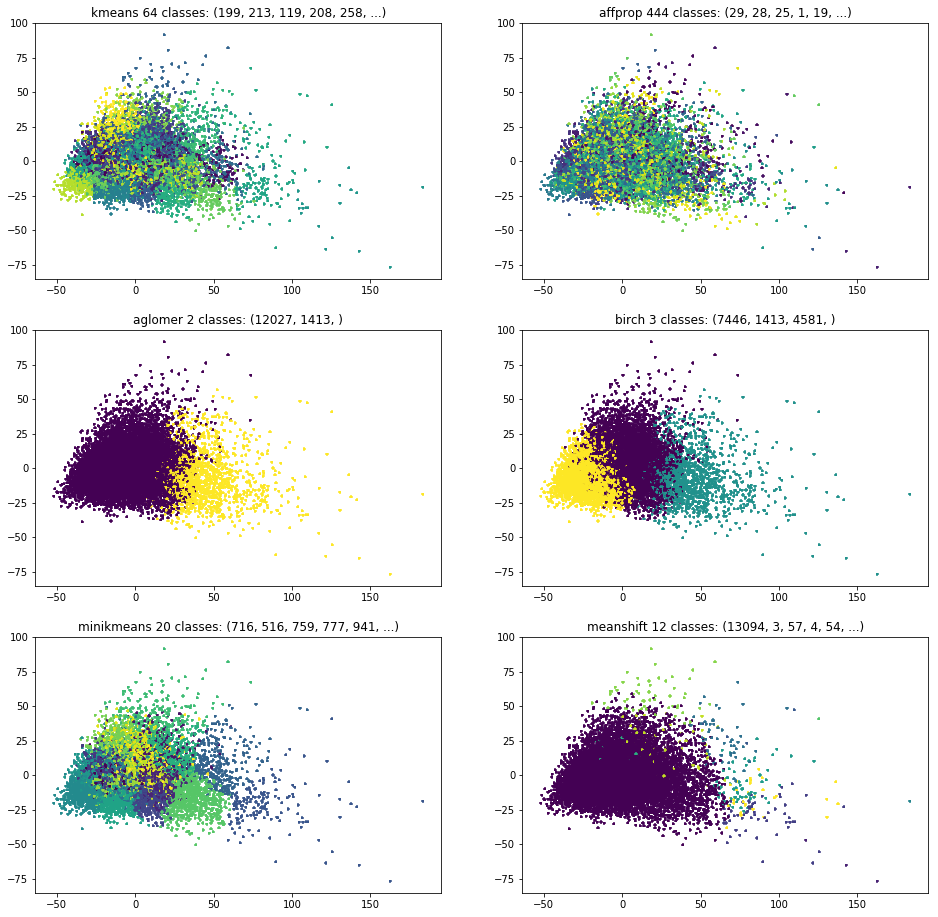

In [13]:
def plot_scatter(ax, pca_result, classification, name=''):
    ax.scatter(pca_result[:,0], pca_result[:,1], 10, classification, \
               marker='+', edgecolors='none')
    classes, counts = np.unique(classification, return_counts=True)
    
    title = '{} {} classes: ('.format(name, len(classes))
    for cnt in counts[:5]:
        title += '{}, '.format(cnt)
    if len(classes) > 5:
        title += '...'
    title += ')'
    ax.set_title(title)

fig, ax = plt.subplots(3, 2, figsize=(16,16))
plot_scatter(ax.flatten()[0], pca_result, kmeans_class_64, 'kmeans')
plot_scatter(ax.flatten()[1], pca_result, affprop_class, 'affprop')
plot_scatter(ax.flatten()[2], pca_result, aglomer_class, 'aglomer')
plot_scatter(ax.flatten()[3], pca_result, birch_class, 'birch')
# plot_scatter(ax.flatten()[4], pca_result, dbscan_class)
plot_scatter(ax.flatten()[4], pca_result, minikmeans_class, 'minikmeans')
plot_scatter(ax.flatten()[5], pca_result, meanshift_class, 'meanshift')
# plot_scatter(ax.flatten()[8], pca_result, spectral_class)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.scatter(featureagg_class[:,0], featureagg_class[:,1], 10, marker='+', edgecolors='none')
featureagg_class.shape

In [ ]:
# Filtering by Mean Shift
classes, counts = np.unique(meanshift_class, return_counts=True)
main_class = classes[np.argmax(counts)]
for cl in classes[classes != main_class]:
    fig, ax = plt.subplots(1, 5, figsize=(16,2))
    selected_fvs = fvs[meanshift_class == cl]
    for i, fv in enumerate(selected_fvs[:5]):
        ax[i].plot(fv)
        ax[i].set_title('Class {}, {}/{}'.format(cl, i+1, len(selected_fvs)))
    

In [ ]:
# Filtering by Mean Shift
classes, counts = np.unique(meanshift_class, return_counts=True)
main_class = classes[np.argmax(counts)]
for cl in classes[classes != main_class]:
    fig, ax = plt.subplots(1, 5, figsize=(12,2))
    selected_particles = particles[meanshift_class == cl]
    for i, prtcl in enumerate(selected_particles[:5]):
        plot_data(prtcl, ax[i])
        ax[i].set_title('Class {}, {}/{}'.format(cl, i+1, len(selected_particles)))
    

In [ ]:
# Stack class images and compute mean

def find_best_orientation(polar_particle, base_polar_particle):
    nr, nt = polar_particle.shape
    
    corr = np.zeros_like(polar_particle)
    for r in range(nr):
        pcircle = polar_particle[r]
        base_pcircle = base_polar_particle[r]
        base_pcircle = np.concatenate((base_pcircle, base_pcircle)) # Copy 4 pi for full correlation
        corr[r,:] = sp.correlate(pcircle, base_pcircle)[:-1]/len(pcircle)
    
    return corr


def compute_mean_particle(particles):
    N, nx, ny = particles.shape
    xi, yi, nr, nt = analysis_helper.getXiYiForPolarCoords(particles.shape[-2:], rmin=5, rmax=min(nx//2, ny//2)-1)
    # Make gap of 5px in center and decrease rmax by 1px to remove edge effects 
    
    polar_particles = np.zeros((N, nr, nt), dtype=particles.dtype)
    for i in range(N):
        p = particles[i]
        p -= np.amin(p) # Make data > 0
        polar_particles[i] = analysis_helper.reprojectImageByCoords(p, xi, yi, nr, nt)
    
    fig, ax = plt.subplots(6, 4, figsize=(16,12))
    for i in range(1, N):
        corr = find_best_orientation(polar_particles[i], polar_particles[0])
        plot_data(polar_particles[0], ax[i-1,0])
        plot_data_cm(corr, ax[i-1,1])
        plot_data(polar_particles[i], ax[i-1,2])
        max_corr = np.argmax(corr, axis=1)
        ax[i-1,3].plot(max_corr, range(nr))
        
    return np.mean(polar_particles, axis=0)
#     return polar_particles[0]


mean_particle = compute_mean_particle(particles[meanshift_class == 2])
# fig, ax = plt.subplots(3, 4, figsize=(12,6))
# classes, counts = np.unique(meanshift_class, return_counts=True)
# main_class = classes[np.argmax(counts)]
# for i, cl in enumerate(classes[classes != main_class]):
#     selected_particles = particles[meanshift_class == cl]
#     mean_particle = compute_mean_particle(selected_particles)
#     plot_data(mean_particle, ax.flatten()[i])

In [ ]:
# Stack class images and compute mean


def find_best_orientation(polar_particle, base_polar_particle, rmin=-1, rmax=-1):
    nr, nt = polar_particle.shape
    
    if rmin == -1:
        rmin = int(nt/(2*np.pi)) # There are more than one pixel in cart projection per pixel in polar projection 
        rmin = 0
    if rmax == -1:
        rmax = nr

    base_polar_particle = np.hstack((base_polar_particle, base_polar_particle)) # Copy 4 pi for full correlation
    
    corr = np.zeros((rmax-rmin, nt), dtype=polar_particle.dtype)
    norm = np.sum(polar_particle[rmin:rmax,:])*np.sum(base_polar_particle[rmin:rmax,:])
    for r in range(rmin, rmax):
        pcircle = polar_particle[r]
        base_pcircle = base_polar_particle[r]
        corr[r-rmin,:] = sp.correlate(pcircle, base_pcircle)[:-1]/norm

    total_corr = np.sum(corr, axis=0)
    total_corr -= np.amin(total_corr)
    total_corr /= np.amax(total_corr)
    return total_corr

def find_best_orientation_weighted(polar_particle, base_polar_particle, rmin=-1, rmax=-1):
    nr, nt = polar_particle.shape
    
    if rmin == -1:
        rmin = int(nt/(2*np.pi)) # There are more than one pixel in cart projection per pixel in polar projection 
        rmin = 0
    if rmax == -1:
        rmax = nr

    base_polar_particle = np.hstack((base_polar_particle, base_polar_particle)) # Copy 4 pi for full correlation
    
    corr = np.zeros((rmax-rmin, nt), dtype=polar_particle.dtype)
    norm = np.sum(polar_particle[rmin:rmax,:])*np.sum(base_polar_particle[rmin:rmax,:])
    for r in range(rmin, rmax):
        pcircle = polar_particle[r]
        base_pcircle = base_polar_particle[r]
        corr[r-rmin,:] = sp.correlate(pcircle, base_pcircle)[:-1]/norm

    total_corr = np.average(corr, weights=np.arange(rmin, rmax), axis=0)
    total_corr -= np.amin(total_corr)
    total_corr /= np.amax(total_corr)
    return total_corr


def compute_mean_particle(particles):
    N, nx, ny = particles.shape
    xi, yi, nr, nt = analysis_helper.getXiYiForPolarCoords(particles.shape[-2:], rmin=5, rmax=min(nx//2, ny//2)-1)
    # Make gap of 5px in center and decrease rmax by 1px to remove edge effects 
    
    polar_particles = np.zeros((N, nr, nt), dtype=particles.dtype)
    for i in range(N):
        p = particles[i]
        p -= np.amin(p) # Make data > 0
        polar_particles[i] = analysis_helper.reprojectImageByCoords(p, xi, yi, nr, nt)
    
    M = min(N,6) 
    
    fig, ax = plt.subplots(M-1, 3, figsize=(16,12))
    for i in range(1, M):
#         corr = find_best_orientation(polar_particles[i], polar_particles[0])
        ax[i-1,1].plot(find_best_orientation(polar_particles[i], polar_particles[0], rmin=0), label='Rmin=0')
#         ax[i-1,1].plot(find_best_orientation(polar_particles[i], polar_particles[0], rmin=5), label='Rmin=5')
#         ax[i-1,1].plot(find_best_orientation(polar_particles[i], polar_particles[0], rmin=10), label='Rmin=10')
        ax[i-1,1].plot(find_best_orientation(polar_particles[i], polar_particles[0], rmin=15), label='Rmin=15')
        ax[i-1,1].plot(find_best_orientation_weighted(polar_particles[i], polar_particles[0]), label='Weighted')
        ax[i-1,1].plot(find_best_orientation_weighted(gaussian_filter(polar_particles[i], 1),
                                                      polar_particles[0]), label='Smoothed')
        ax[i-1,1].legend()
    
#     polar_particle -= np.amin(polar_particles)
#     base_polar_particle -= np.amin(base_polar_particle)
        plot_data_cm(gaussian_filter(polar_particles[i], 1), ax[i-1,2], cmap='gray')
        plot_data_cm(polar_particles[i], ax[i-1,0], cmap='gray')
        
    return np.mean(polar_particles, axis=0)
#     return polar_particles[0]


mean_particle = compute_mean_particle(particles[meanshift_class == 2])
# fig, ax = plt.subplots(3, 4, figsize=(12,6))
# classes, counts = np.unique(meanshift_class, return_counts=True)
# main_class = classes[np.argmax(counts)]
# for i, cl in enumerate(classes[classes != main_class]):
#     selected_particles = particles[meanshift_class == cl]
#     mean_particle = compute_mean_particle(selected_particles)
#     plot_data(mean_particle, ax.flatten()[i])

In [ ]:
import time

N, nx, ny = particles.shape
xi, yi, nr, nt = analysis_helper.getXiYiForPolarCoords(particles.shape[-2:], rmin=5, rmax=min(nx//2, ny//2)-1)
# Make gap of 5px in center and decrease rmax by 1px to remove edge effects 
N = 2
polar_particles = np.zeros((N, nr, nt), dtype=particles.dtype)
for i in range(N):
    p = particles[i]
    p -= np.amin(p) # Make data > 0
    polar_particles[i] = analysis_helper.reprojectImageByCoords(p, xi, yi, nr, nt)


start = time.time()
for i in range(1000):
    find_best_orientation(polar_particles[1], polar_particles[0])
end = time.time()
print('Time:', end - start)

start = time.time()
for i in range(1000):
    find_best_orientation_old(polar_particles[1], polar_particles[0])
end = time.time()
print('Time:', end - start)


### Old is faster (correlate each row individually)

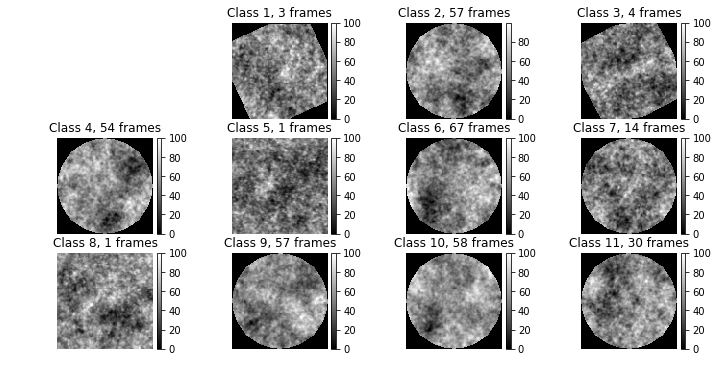

In [14]:
# Stack class images and compute mean

def merge_particles(particles, orientations, fill_border=True):
    rotated_particles = np.zeros_like(particles)
    
    for i in range(particles.shape[0]):
        ndimage.interpolation.rotate(particles[i], \
                                     orientations[i], \
                                     reshape=False, \
                                     output=rotated_particles[i])

    if fill_border:
        mean_particle = np.true_divide(np.sum(rotated_particles, axis=0), np.sum(rotated_particles!=0, axis=0))
    else:
        mean_particle = np.sum(rotated_particles, axis=0)
        border_mask = (np.amax(rotated_particles == 0, axis=0) == 1)
        mean_particle[border_mask] = np.amin(mean_particle[~border_mask])

    return normalize_image(mean_particle)


def normalize_image(image):
    image -= np.amin(image) # Make data >= 0
    image /= np.amax(image)/100.0 # Make 0 <= data <= 100
    return image


def find_best_orientation(polar_particle, base_polar_particle, rmin=-1, rmax=-1):
    nr, nt = polar_particle.shape
    
    if rmin == -1:
        rmin = int(nt/(2*np.pi)) # There are more than one pixel in cart projection per pixel in polar projection 
    if rmax == -1:
        rmax = nr

    base_polar_particle = np.hstack((base_polar_particle, base_polar_particle)) # Copy 4 pi for full correlation
    
    corr = np.zeros((rmax-rmin, nt), dtype=polar_particle.dtype)
    norm = np.sum(polar_particle[rmin:rmax,:])*np.sum(base_polar_particle[rmin:rmax,:])
    for r in range(rmin, rmax):
        pcircle = polar_particle[r]
        base_pcircle = base_polar_particle[r]
        corr[r-rmin,:] = sp.correlate(pcircle, base_pcircle)[:-1]/norm
    
    return np.argmax(np.average(corr, \
                                weights=np.arange(rmin, rmax), \
                                axis=0)
                    ) # Shift opposite direction, to move best correlation in zero


def compute_mean_particle(particles, smooth_factor=0):
    N, nx, ny = particles.shape
    xi, yi, nr, nt = analysis_helper.getXiYiForPolarCoords(particles.shape[-2:], rmax=min(nx//2, ny//2))
    rmin_gap = 5
    rmax_gap = 1
    # Make gap of 5px in center and decrease rmax by 1px to remove edge effects 
    
    polar_particles = np.zeros((N, nr, nt), dtype=particles.dtype)
    for i in range(N):
        p = normalize_image(particles[i])
        polar_particles[i] = analysis_helper.reprojectImageByCoords(p, xi, yi, nr, nt)
        if smooth_factor > 0:
            polar_particles[i] = gaussian_filter(polar_particles[i], smooth_factor)
    
    mean_particle = particles[0]
    polar_mean = polar_particles[0]
    
    max_iter = 10
    shifts = np.zeros((max_iter,N))
    for t in range(max_iter):
        for i in range(N):
            best_shift = find_best_orientation(polar_particles[i,rmin_gap:-rmax_gap], \
                                               polar_mean[rmin_gap:-rmax_gap])   
            shifts[t,i] = best_shift
            
        new_mean = merge_particles(particles, shifts[t,:]*(360/nt), fill_border=False)

        if (new_mean == mean_particle).all():
            break
        else:
            mean_particle = new_mean
            polar_mean = analysis_helper.reprojectImageByCoords(mean_particle, xi, yi, nr, nt)

    shifts = shifts[:(t+1)] # Cut empty part of array
    shifts = shifts[:,shifts[-1].argsort()] # Sort by last orientations

    return mean_particle, shifts


fig, ax = plt.subplots(3, 4, figsize=(12,6))
classes, counts = np.unique(meanshift_class, return_counts=True)
main_class = classes[np.argmax(counts)]
for i, cl in enumerate(classes):
    if cl == main_class:
        ax.flatten()[i].axis('off')
        continue
    mean_particle, shifts = compute_mean_particle(particles[meanshift_class == cl])
    plot_data_cm(mean_particle, ax.flatten()[i], cmap='gray')
    ax.flatten()[i].set_title('Class {}, {} frames'.format(cl, counts[i]))

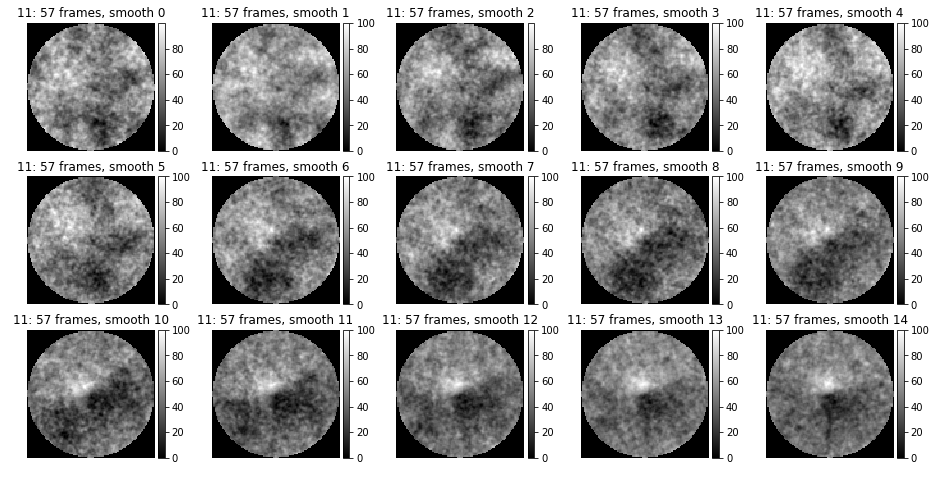

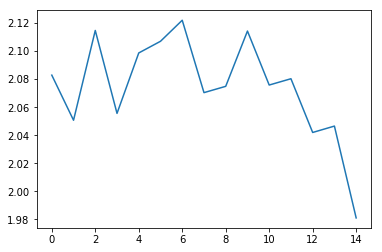

In [15]:
fig, ax = plt.subplots(3, 5, figsize=(16,8))
entropy = []
for i, axes in enumerate(ax.flatten()):
    mean_particle, shifts = compute_mean_particle(particles[meanshift_class == 2], smooth_factor=i)
    plot_data_cm(mean_particle, axes, cmap='gray')
    axes.set_title('{}: {} frames, smooth {}'.format(cl, counts[2], i))
    entropy.append(get_entropy(mean_particle))
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(entropy)

 31%

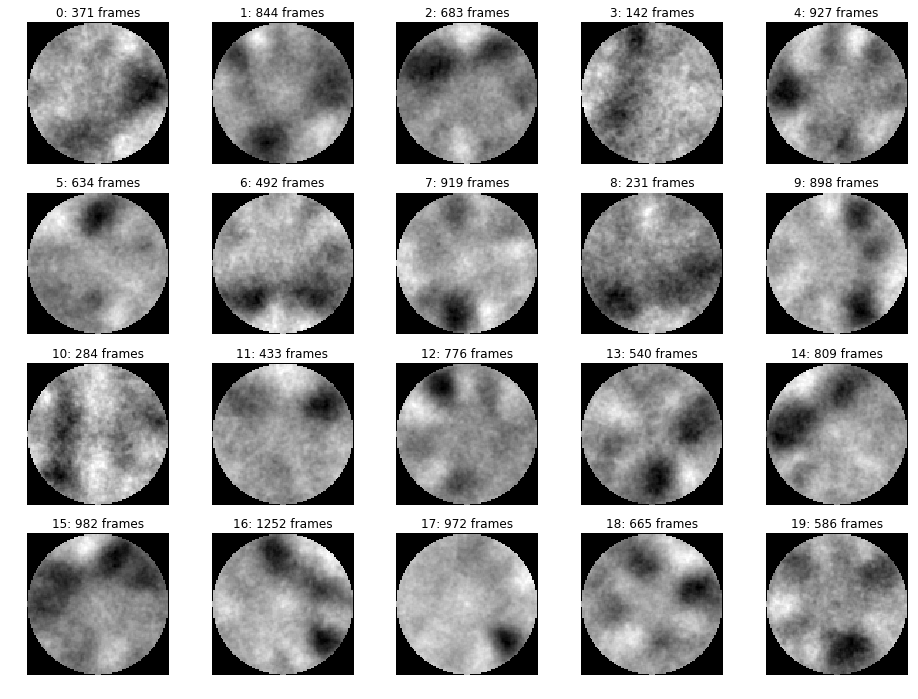

In [16]:
def plot_mean_particles(particles, classification, smooth_factor):
    fig, ax = plt.subplots(4, 5, figsize=(16,12))
    classes, counts = np.unique(classification, return_counts=True)
    for i, cl in enumerate(classes[:20]):
        print('\r {}%'.format(int(100.0*(i+1)/64)), end='')
        mean_particle, shifts = compute_mean_particle(particles[classification == cl], smooth_factor)
        plot_data(mean_particle, ax.flatten()[i])
        ax.flatten()[i].set_title('{}: {} frames'.format(cl, counts[i]))

plot_mean_particles(particles, kmeans_class_20, smooth_factor=2)

In [ ]:
# Smooth 6 px

def plot_mean_particles(particles, classification):
    fig, ax = plt.subplots(8, 8, figsize=(16,16))
    classes, counts = np.unique(classification, return_counts=True)
    for i, cl in enumerate(classes[:64]):
        print('\r {}%'.format(int(100.0*(i+1)/64)), end='')
        mean_particle, shifts = compute_mean_particle(particles[classification == cl], smooth_factor=6)
        plot_data(mean_particle, ax.flatten()[i])
        ax.flatten()[i].set_title('{}: {} frames'.format(cl, counts[i]))

plot_mean_particles(particles, kmeans_class)

In [52]:
mrc_dir = '../cryoem_data/'
xmipp_class_file = '../cryoem_data/xmipp_classification/level_03/level_classes.xmd'
xmipp_pos_files = [f for f in os.listdir(xmipp_particles_dir) if f[-4:] == '.pos']

particle_coords = []
for i, pos_file in enumerate(xmipp_pos_files):
    coords = []
    for line in open(xmipp_particles_dir + pos_file, 'r'):
        l = line.strip().split()
        if len(l) < 4:
            continue
        coords.append([int(l[0]), int(l[1])])
        
particle_coords.append(np.array(coords))


(392, 2)
[array([[2168,  110],
       [ 401,  130],
       [ 692,  301],
       [ 692,  461],
       [ 702,  130],
       [ 793,  361],
       [ 783,  612],
       [2379,  140],
       [ 793,  180],
       [1204,  341],
       [1204,  220],
       [1375,  150],
       [1686,  160],
       [ 160,  160],
       [ 240,  160],
       [1525,  160],
       [1536,  321],
       [2298,  160],
       [3373,  170],
       [3543,  200],
       [3152,  230],
       [3724,  210],
       [2389,  261],
       [2871,  271],
       [1013,  281],
       [1686,  281],
       [2098,  311],
       [1375,  532],
       [1375,  321],
       [ 381,  341],
       [ 401,  481],
       [3614,  351],
       [ 491,  401],
       [2389,  361],
       [2379,  481],
       [2560,  361],
       [2730,  381],
       [1957,  371],
       [3463,  391],
       [ 210,  401],
       [1013,  401],
       [1024,  522],
       [1536,  421],
       [3192,  471],
       [1204,  481],
       [ 240,  501],
       [ 220,  642],
   

In [248]:
def read_stk_sequence(stk_file):
    spyder_stack = pil_image.open(stk_file)
    first_img = np.array(spyder_stack)
    
    imgbytes = spyder_stack.imgbytes
    
    images = [first_img]
    
    for i in range(1, spyder_stack.n_frames):
        start_offset = 2*spyder_stack.hdrlen + i*(spyder_stack.hdrlen + spyder_stack.imgbytes)
        
        with open(stk_file, "rb") as fp:
            fp.seek(start_offset)
            img_buffer = fp.read(imgbytes)
            img = np.frombuffer(img_buffer, dtype=first_img.dtype).reshape((first_img.shape))
            images.append(img)
    
    return np.stack(images)


def read_stk_image(stk_file, frame=0):
    spyder_stack = pil_image.open(stk_file)
    first_img = np.array(spyder_stack)
    if frame == 0:
        return first_img

    if frame >= spyder_stack.n_frames:
        raise ValueError('Cannot read frame %d from file with %d frames' % (frame, spyder_stack.n_frames))
    
    imgbytes = spyder_stack.imgbytes
    start_offset = 2*spyder_stack.hdrlen + frame*(spyder_stack.hdrlen + spyder_stack.imgbytes)
        
    with open(stk_file, "rb") as fp:
        fp.seek(start_offset)
        img_buffer = fp.read(imgbytes)
        img = np.frombuffer(img_buffer, dtype=first_img.dtype).reshape((first_img.shape))
        
        return img


stk_file = '../../cryoem/cryoem_data/xmipp_extracted_particles/FoilHole_1276754_Data_1274583_1274584_20180303_2055_frames.stk'
stk_frames = read_stk_sequence(stk_file)
stk_image = read_stk_image(stk_file,10)

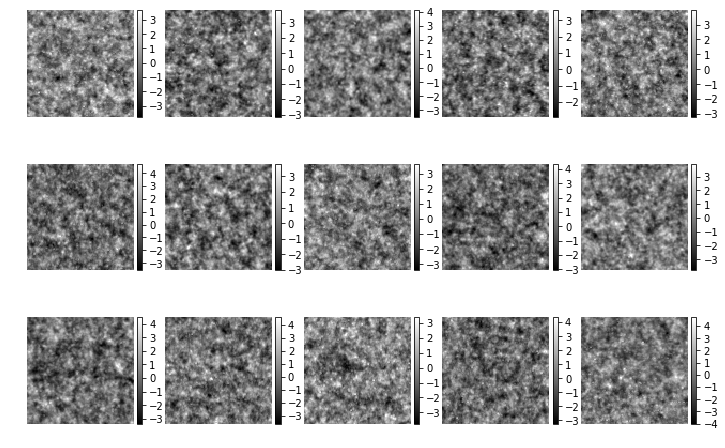

In [247]:
fig, ax = plt.subplots(3, 5, figsize=(12,8))
for i, a in enumerate(ax.flatten()):
    plot_data_cm(stk_frames[i], a, cmap='gray')

In [232]:
def parse_xmd_section(line_buffer):
    column_names = []
    line_idx = 2 # Start from 3rd line
    
    while line_buffer[line_idx][0] == '_':
        column_names.append(line_buffer[line_idx][1:])
        line_idx += 1

    data_buffer = StringIO('\n'.join(line_buffer[line_idx:]))
    return pandas.read_table(data_buffer, names=column_names)


def parse_xmd_file(xmd_file):
    result_tables = []
    result_names = []
    with open(xmd_file, 'r') as f:
        line_buffer = []
        for line in f:
            if line[0] == '#':
                continue
            
            if not line.strip():
                if line_buffer[0][:5] != 'data_':
                    line_buffer.clear()    # Non compatible data format
                    continue
    
                result_tables.append(parse_xmd_section(line_buffer))
                result_names.append(line_buffer[0][5:])
                line_buffer.clear()
            
            line_buffer.append('\t'.join(line.strip().split()))

    return result_tables, result_names


xmd_file = '../../cryoem/cryoem_data/xmipp_classification/level_03/level_classes.xmd'
xmd_data, xmd_names = parse_xmd_file(xmd_file)
for data, name in zip(xmd_data, xmd_names):
    print('Table:' + name)
    print(data)
    print('')

Table:classes
    ref                                              image  classCount
0     1  000001@Runs/000269_XmippProtCL2D/extra/level_0...         153
1     2  000002@Runs/000269_XmippProtCL2D/extra/level_0...         275
2     3  000003@Runs/000269_XmippProtCL2D/extra/level_0...          92
3     4  000004@Runs/000269_XmippProtCL2D/extra/level_0...         149
4     5  000005@Runs/000269_XmippProtCL2D/extra/level_0...         240
5     6  000006@Runs/000269_XmippProtCL2D/extra/level_0...         238
6     7  000007@Runs/000269_XmippProtCL2D/extra/level_0...         217
7     8  000008@Runs/000269_XmippProtCL2D/extra/level_0...         113
8     9  000009@Runs/000269_XmippProtCL2D/extra/level_0...         208
9    10  000010@Runs/000269_XmippProtCL2D/extra/level_0...          40
10   11  000011@Runs/000269_XmippProtCL2D/extra/level_0...          75
11   12  000012@Runs/000269_XmippProtCL2D/extra/level_0...         266
12   13  000013@Runs/000269_XmippProtCL2D/extra/level_0...     

In [ ]:
# Equlise background
i = np.random.randint(mrc_data.shape[0])
i = 0

def remove_background(image, sigma=40):
    mean = gaussian_filter(image, sigma)
    image = image - mean
    return image
    
step_num = 10
step_val = 5
image_width = mrc_data.shape[2]//step_num

fig, ax = plt.subplots(2, step_num, figsize=(41,41))
plt.tight_layout(pad=0.05)

image = mrc_data[i, :mrc_data.shape[1]//2, :image_width]
image -= np.mean(image)
plot_data(image, ax[0,0])
plot_data(image, ax[1,0])
ax[0,0].set_title('Original')

norm = colors.Normalize(vmin=np.amin(image), vmax=np.amax(image))

for i in range(1, step_num):
    bg = remove_background(image, step_val*i)
    im = ax[0,i].imshow(bg, cmap="gray", norm=norm)
    ax[0,i].set_title('Sigma = {}'.format(step_val*i))
    c = Circle((image_width//2, image.shape[0]//2), step_val*i, edgecolor='b', facecolor='none', linewidth=2)
    ax[0,i].add_artist(c)
    im = ax[1,i].imshow(image - bg, cmap="gray", norm=norm)


In [ ]:
step_num = 10
step_val = 10

fig, ax = plt.subplots(1, 1, figsize=(16,10))
plt.tight_layout(pad=0.05)

image = mrc_data[i]
image -= np.mean(image)
rad_mean_freq_orig = compute_rad_mean_freq(image)[:100]
ax.plot(rad_mean_freq_orig, label='Original')

border_val = []
border_pos = []

for i in range(1, step_num):
    rad_mean_freq = compute_rad_mean_freq(remove_background(image, step_val*i))[:100]
    ax.plot(rad_mean_freq, label='Sigma = {}'.format(step_val*i))
    
    half_pos = np.argmax((rad_mean_freq_orig - rad_mean_freq*2) < 0)
    half_val = rad_mean_freq[half_pos]
    border_pos.append(half_pos)
    border_val.append(half_val)

    
ax.plot(border_pos, border_val, label='Freq decayed by 2')
ax.set_yscale('log')
ax.set_ylim([1e3, 1e7])
ax.legend()

## Gauss smooth remove details above certain size, effect is measured by decay of frequency values in Fourier space.
## We estimate optimal sigma for background estimation equal 40, because frequency values decreased by 2 for 1/20 of image (details bigger that 200 px), and particles <100 pixels in size should save all details

In [ ]:
i = np.random.randint(mrc_data.shape[0])

image = mrc_data[i,:1500]
norm_image = image - np.mean(image)

fig, ax = plt.subplots(3, 1, figsize=(8,8))
plot_data_cm(remove_background(image), ax[0], cmap='gray')
plot_data_cm(remove_background(norm_image), ax[1], cmap='gray')
plot_data_cm(remove_background(image) - remove_background(norm_image), ax[2], cmap='gray')


## remove_background(image) AND remove_background(norm_image) have very small difference (order 1e-6 of data)